## Importing Necessary Libraries

In [52]:
!pip install graphviz

  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 668.0 kB/s eta 0:00:000:00:01


In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

import datetime as dt
from datetime import timedelta

from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from sklearn.pipeline import make_pipeline, Pipeline

from numpy import arange
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge

import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 50)
sns.set_style('whitegrid')

## Loading Dataframes

### MasterQuote dataframe

In [197]:
df_MasterQuote = pd.read_csv('Dataset/MasterQuote.csv', header = 0)

To make my life easier, I created a block of code that will return the cleaned dataframe that I did in my data engineering notebook. This is so I can keep calling the cleaned dataframe and do not have to run through all of my engineering code everytime I want to run my regression models

This code block will put all of my data engineering that I did in my previous notebook into one block for the MasterQuote dataframe.  This will be. alarge comilation of previously commented code

In [198]:
#The comments for this code can be found in my Data Engineering section

mast_nan_percentage = df_MasterQuote.isnull().mean() * 100
master_cleaned = df_MasterQuote.loc[:, mast_nan_percentage <= 20]

mast_object_columns = master_cleaned.select_dtypes(include=['object']).columns
mast_unique_counts = master_cleaned[mast_object_columns].nunique()

mast_cat = [col for col in mast_object_columns if col not in ['AbilitecContactID', 'AbilitecHouseholdID', 'QuoteNumber', 'QuoteInitiatedTime', 'TermExpirationDate', 'TermEffectiveDate', 'PolicyStateCode']]#, 'GaragingState' ]]
mast_encoded = pd.get_dummies(master_cleaned, columns=mast_cat, drop_first=False)

master_cleaned = mast_encoded

master_cleaned = master_cleaned.drop(columns=master_cleaned.select_dtypes(include=['object']).columns)

info for master cleaned df

In [199]:
master_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34975 entries, 0 to 34974
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   MQuotedTotalPayment                         34975 non-null  float64
 1   DriversActive                               34975 non-null  int64  
 2   PolicyTerm                                  34975 non-null  int64  
 3   DriverNumber                                34975 non-null  int64  
 4   DriverCount                                 34975 non-null  int64  
 5   BiFcCoverageInd_BI FC                       34975 non-null  uint8  
 6   BiFcCoverageInd_BI NOFC                     34975 non-null  uint8  
 7   BiFcCoverageInd_NOBI FC                     34975 non-null  uint8  
 8   BiFcCoverageInd_NOBI NOFC                   34975 non-null  uint8  
 9   CoverageTypeDescription_Bond                34975 non-null  uint8  
 10  CoverageTy

## Creating Test/Train Data split
* master_cleaned includes features and a target variable
* create X dataset (only includes features)
* create y dataset (only includes target variable)
* creating train and test datasets for X and y

- then I will scale the data using standard scaler

My X will include all columns in the dataframe except my target variable, 'MQuotedTotalPayment', and all other columns that are categorical that I did not do dummy variables on.

My y will include my target variable 'MQuotedTotalPayment'

In [200]:
# keeping features for x
X = master_cleaned.drop(['MQuotedTotalPayment'], axis = 1)

#keep target variable only for y
y = master_cleaned['MQuotedTotalPayment']

creating train test split

In [201]:
# I will split the data doing a 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

making discriptions and displaying head of each datframe to ensure each split was created correctly

In [202]:
display(X_train.head())
y_train.describe()

,DriversActive,PolicyTerm,DriverNumber,DriverCount,BiFcCoverageInd_BI FC,BiFcCoverageInd_BI NOFC,BiFcCoverageInd_NOBI FC,BiFcCoverageInd_NOBI NOFC,CoverageTypeDescription_Bond,CoverageTypeDescription_Full Coverage,CoverageTypeDescription_Liability Only,GaragingState_AK,GaragingState_AL,GaragingState_AR,GaragingState_AZ,GaragingState_CA,GaragingState_CO,GaragingState_CT,GaragingState_DC,GaragingState_DE,GaragingState_FL,GaragingState_GA,GaragingState_IA,GaragingState_ID,GaragingState_IL,GaragingState_IN,GaragingState_KS,GaragingState_KY,GaragingState_LA,GaragingState_MD,GaragingState_ME,GaragingState_MN,GaragingState_MO,GaragingState_MS,GaragingState_MT,GaragingState_NC,GaragingState_ND,GaragingState_NE,GaragingState_NH,GaragingState_NM,GaragingState_NV,GaragingState_NY,GaragingState_OH,GaragingState_OK,GaragingState_OR,GaragingState_PA,GaragingState_RI,GaragingState_SC,GaragingState_SD,GaragingState_TN,GaragingState_TX,GaragingState_UT,GaragingState_VA,GaragingState_VT,GaragingState_WA,GaragingState_WI,GaragingState_WV,GaragingState_WY,NamedInsuredMaritalStatus_Civil Union,NamedInsuredMaritalStatus_Divorced,NamedInsuredMaritalStatus_Domestic Partner,NamedInsuredMaritalStatus_Married,NamedInsuredMaritalStatus_Separated,NamedInsuredMaritalStatus_Single,NamedInsuredMaritalStatus_Widowed
9987,3,12,1,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
26269,2,6,1,7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
30475,1,12,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
34070,1,6,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
811,1,6,1,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


count    27980.000000
mean      1553.616598
std       1233.879665
min          0.000000
25%        790.000000
50%       1259.000000
75%       2010.250000
max      18803.000000
Name: MQuotedTotalPayment, dtype: float64

continuation of previous code

In [203]:
display(X_test.head())
y_test.describe()

,DriversActive,PolicyTerm,DriverNumber,DriverCount,BiFcCoverageInd_BI FC,BiFcCoverageInd_BI NOFC,BiFcCoverageInd_NOBI FC,BiFcCoverageInd_NOBI NOFC,CoverageTypeDescription_Bond,CoverageTypeDescription_Full Coverage,CoverageTypeDescription_Liability Only,GaragingState_AK,GaragingState_AL,GaragingState_AR,GaragingState_AZ,GaragingState_CA,GaragingState_CO,GaragingState_CT,GaragingState_DC,GaragingState_DE,GaragingState_FL,GaragingState_GA,GaragingState_IA,GaragingState_ID,GaragingState_IL,GaragingState_IN,GaragingState_KS,GaragingState_KY,GaragingState_LA,GaragingState_MD,GaragingState_ME,GaragingState_MN,GaragingState_MO,GaragingState_MS,GaragingState_MT,GaragingState_NC,GaragingState_ND,GaragingState_NE,GaragingState_NH,GaragingState_NM,GaragingState_NV,GaragingState_NY,GaragingState_OH,GaragingState_OK,GaragingState_OR,GaragingState_PA,GaragingState_RI,GaragingState_SC,GaragingState_SD,GaragingState_TN,GaragingState_TX,GaragingState_UT,GaragingState_VA,GaragingState_VT,GaragingState_WA,GaragingState_WI,GaragingState_WV,GaragingState_WY,NamedInsuredMaritalStatus_Civil Union,NamedInsuredMaritalStatus_Divorced,NamedInsuredMaritalStatus_Domestic Partner,NamedInsuredMaritalStatus_Married,NamedInsuredMaritalStatus_Separated,NamedInsuredMaritalStatus_Single,NamedInsuredMaritalStatus_Widowed
5172,1,6,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
14265,1,6,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
21343,1,6,1,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14528,1,6,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
23920,1,12,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


count     6995.000000
mean      1556.867537
std       1225.996937
min          0.000000
25%        787.960000
50%       1265.920000
75%       2038.460000
max      16473.000000
Name: MQuotedTotalPayment, dtype: float64

we can see that the y test has less than the y train so the 80/20 split worked

### Brief Summary
* I split the data into a train set and a test set.  This was successfully done and we can see that by the count in the previous code.  The count for the y_test is 6995 while the count for the y_train is 27980.  This means that our train test split works

## Scaling the data
* We are going to use the standard scaler to scale the data
* This ensures that all features are on a standard scale and will increase model performance

In [204]:
sc = StandardScaler()

#fit the x train data (calculating the means and sd of each column of X_train)
sc.fit(X_train)

#transform train data
X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

#transform test data
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

changing scaled data to the original x_train and X_test so that everytime these variables are called it will reflect the trained data

In [205]:
# changing the X_train and X_test to the scaled versions of the data
X_train = X_train_sc
X_test = X_test_sc

### Brief Summary
* I scaled the data to ensure that it was easy to work with.  This ensures that all features are on standard scale and will in turn significantly increase the model performance

## Building the Lasso Model
* This will build a lasso model and assess which coefficients are significant predictors
* I will use Gridsearch to find the best alpha value for the lasso model

* This block of code will use gridsearch to determine the best alpha value for the lasso model to ensure we get the most accurate predictions

In [137]:
#define range of alpha values
alpha_values = np.arange(0.01, 10, 0.1)

# create the lasso model
lasso = Lasso()

#set up parameter grid
param_grid = {'alpha': alpha_values}

#set up repeated k-fold corss-validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

#set up grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

#fit the model on full training dataset
grid_search.fit(X_train, y_train)

#Get best alpha value
best_alpha = grid_search.best_params_['alpha']

print(f'Best alpha value: {best_alpha}')

/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.958e+08, tolerance: 3.439e+06
  model = cd_fast.enet_coordinate_descent(
/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.809e+08, tolerance: 3.398e+06
  model = cd_fast.enet_coordinate_descent(
/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+07, tolerance: 3.385e+06
  model = cd_fast.enet_coordinate_descent(
/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+06, tolerance: 3.426e+06
  model = cd_fast.enet_coordinate_descent(
/Users/marshallsmith/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best alpha value: 0.6100000000000001


* This block of code will take the best alpha value previously found in the grid search and implement it into the lasso model.  This will allow us to get the most accurate predictions
* The code will then return the RMSE, MAE, Rsquared, and MAPE for the best fit lasso model

In [147]:
#creating lasso best to be the lasso model with best fit alpha value
lasso_best = Lasso(alpha=best_alpha)

# fitting lasso best to the X_train and y_train
lasso_best.fit(X_train, y_train)

#assigning the predictions to y_pred_best
y_pred_best = lasso_best.predict(X_test)

#y_hat_test will be the best y predictions
y_hat_test = y_pred_best

#getting RMSE, MAE, Rsquared, and MAPE
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_hat_test)
test_r_squared = r2_score(y_test, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test, y_hat_test) 

#printing out the statistics rounded to 2 decimal places
print(f'The test RMSE is:\t{round(test_rmse, 2)}')
print(f'The test MAE is:\t{round(test_mae, 2)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 3)}')
print(f'The test MAPE is:\t{round(test_mape, 2)}')

The test RMSE is:	828.15
The test MAE is:	534.32
The test Rsquared is:	0.544
The test MAPE is:	1.2838349354145272e+17


## Explaining Lasso Test Statistics
* This code will explain in depth what each one of these statistics mean in relation to the model and dataset

#### RMSE
* 828.15
    * The RMSE measures the average difference between values predicted by a model and the actual values. In other words, it gives us an idea of how far, on average, the predictions are from the actual values.  This means that on average, the Lasso model predictions are off by 828 units.  This is a high RMSE and shows that the model does not do a great job at predicting the target variable which in this case is the total payment
    
#### MAE
* 534.32
    * MAE is different from RMSE because it shows less significance to outliers. It calculates the average of the absolute differences between the predicted values and the actual values.  The MAE for the Lasso model is 534.32 which means on average the predictions are off by about 534.32 units.  This is a decently high MAE but not extremely high.
    
#### R-Squared
* 54%
    * Rsquared measures the amount of variance in the target variable (in this case 'MQuotedTotalPayment').  the rsquared ranges from 0-1 where 1 means the model perfectly predicts the target variable while 0 means the model doesnt predict the target variable at all.  In this case, 54% of the variance in MQuotedTotalPayment can be explained by the predictor variables in the model. This is a decent rsquared and argues that the model does a decent job predicting the target variable
    
#### MAPE
* 128%
    * MAPE tells us how far off our prediction is from the actual value as a percentage.  This MAPE of 128% shows that our predictions are way off from the actual values in many columns and this coul dbe due to a large amount of outliers, or pieces of data that behave unpredictably.  This is a good statistic to understand how the data behaves

### Significant Predictors
* I will now assess the significant predictors according to the lasso model.  This can be done by getting teh coefficients.
* I will then assess which coefficients are not 0 which would imply significance.  The higher the coefficient, the more significant the predictor is

In [148]:
#coefficients will be teh coefficients of each predictor
coefficients = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['Coefficient'])
print("LASSO Coefficients:\n", coefficients)

#This will identofy significant predictors which are the coef
#that aren't 0
significant_predictors = coefficients[coefficients['Coefficient'] != 0]

#making them in decending order
significant_predictors = significant_predictors.reindex(
    significant_predictors['Coefficient'].abs().sort_values(ascending=False).index
)

print("\nSignificant Predictors:\n", significant_predictors)

LASSO Coefficients:
                                             Coefficient
DriversActive                                202.794013
PolicyTerm                                   428.318635
DriverNumber                                  36.120330
DriverCount                                   85.809301
BiFcCoverageInd_BI FC                        452.983085
...                                                 ...
NamedInsuredMaritalStatus_Domestic Partner     0.474481
NamedInsuredMaritalStatus_Married            -71.767552
NamedInsuredMaritalStatus_Separated            0.000000
NamedInsuredMaritalStatus_Single             127.669655
NamedInsuredMaritalStatus_Widowed             11.710883

[65 rows x 1 columns]

Significant Predictors:
                                             Coefficient
BiFcCoverageInd_BI FC                        452.983085
PolicyTerm                                   428.318635
BiFcCoverageInd_NOBI NOFC                   -306.459002
GaragingState_FL                  

Now I will create a bar chart that helps me visualize which predictors are most significant to the dataset.
* This bar graph will only show the top 20 significant predictors to make it easier to read

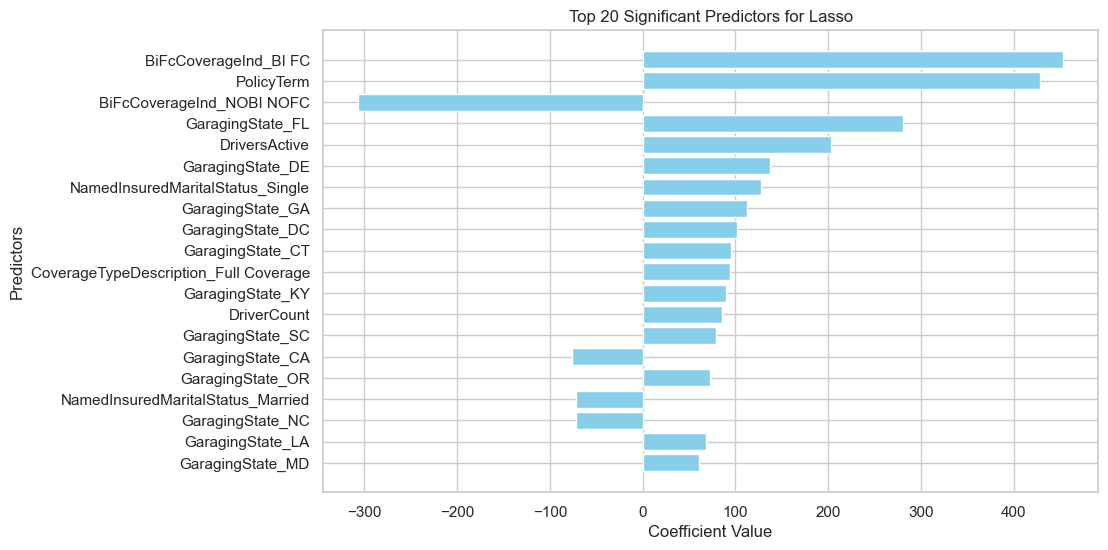

In [149]:
#selecting the top 20 predictors by absolute value
top_20_predictors = significant_predictors.loc[
    significant_predictors['Coefficient'].abs().nlargest(20).index
]



#Plotting the top 20 coef
plt.figure(figsize=(10, 6))
plt.barh(top_20_predictors.index, top_20_predictors['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Top 20 Significant Predictors for Lasso')
plt.gca().invert_yaxis()  # Optional: Highest importance at the top
plt.show()

### Significant Predictors
* The top 5 predictors according to the lasso model is FC coverage, Policy term, and NOFC coverage, Garaging state of Florida and drivers active

Now I will create a dataframe with the lasso predictions, the actual values, and the residuals which show how far off each prediction is

In [141]:
#y_residuals is teh new dataframe
y_residuals = pd.DataFrame(y_test.reset_index())

#df_lasso_pred contains the lasso predictions
df_lasso_pred = pd.DataFrame(y_pred_best)

#i will then merge the two dataframes
y_residuals = pd.concat([y_residuals, df_lasso_pred], axis = 1)

#then rename colum to lasso pred
y_residuals = y_residuals.rename(columns = {0:'lasso_pred'})

#creating column for the residuals
y_residuals['Residuals'] = y_residuals['MQuotedTotalPayment'] - y_residuals['lasso_pred']

#displaying teh new dataframe
y_residuals.head()

,index,MQuotedTotalPayment,lasso_pred,Residuals
0,5172,2446.00,1827.882718,618.117282
1,14265,1398.00,1561.558516,-163.558516
2,21343,456.00,-70.386051,526.386051
3,14528,665.00,30.865528,634.134472
4,23920,1401.92,2345.333886,-943.413886


Create a histogram that shows the lasso residuals

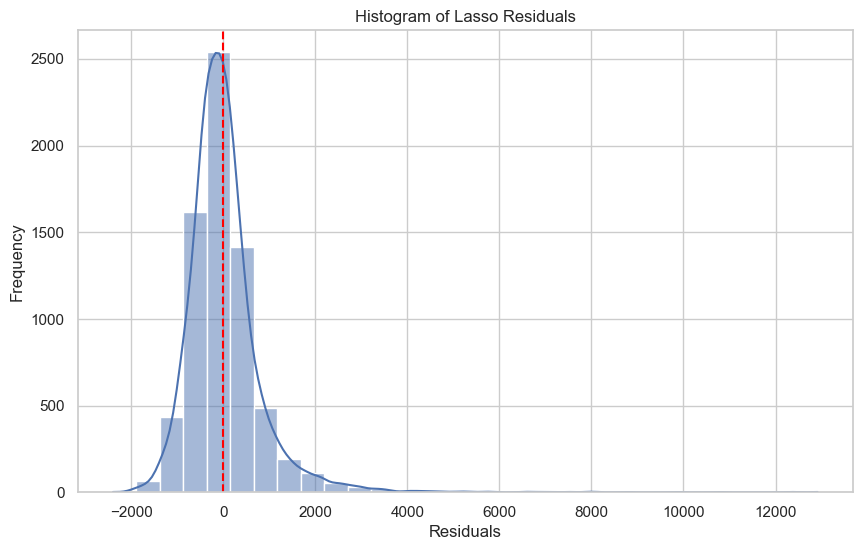

In [142]:
#plotting histogram for lasso residuals
plt.figure(figsize=(10, 6))
sns.histplot(y_residuals['Residuals'], bins=30, kde=True)
plt.title('Histogram of Lasso Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Lasso Visualization
* This section will allow us to visualize the predictions compared to the actual values

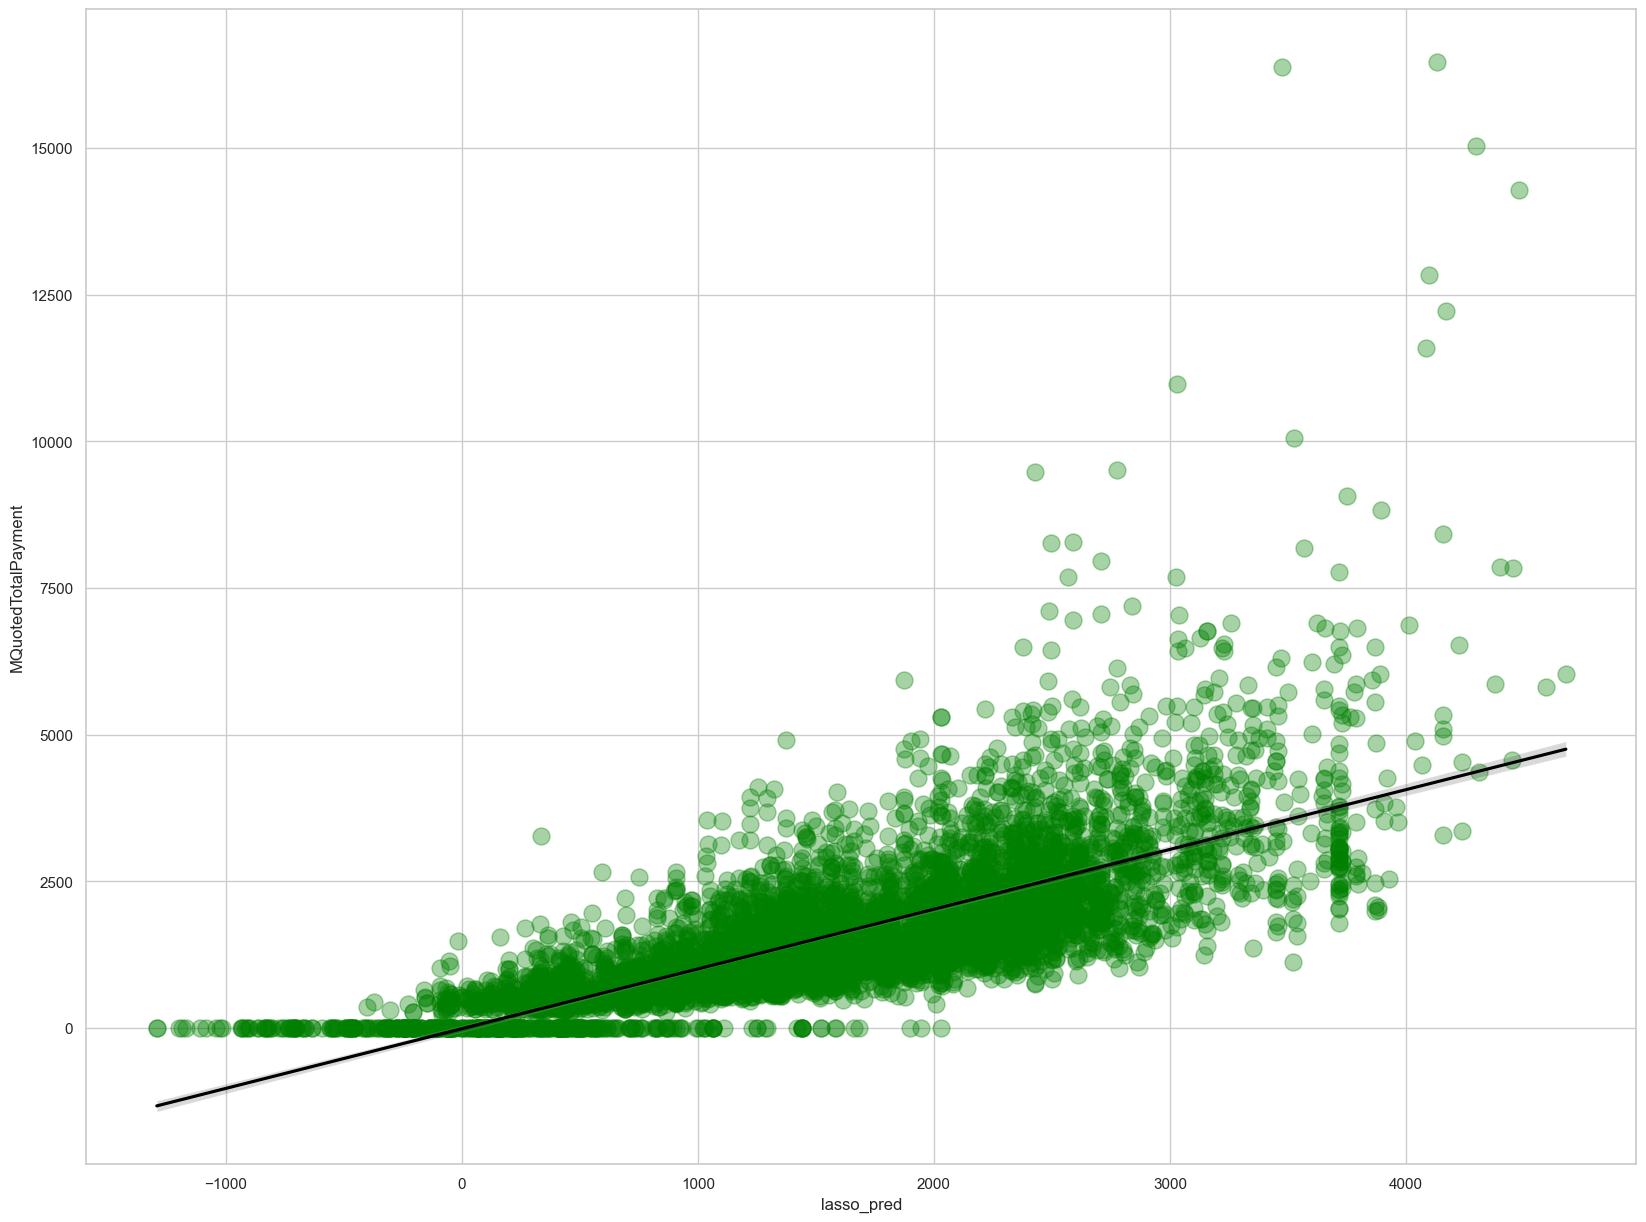

In [143]:
#using seaborn to create a visualization
sns.set(style='whitegrid')
plt.figure(figsize=(20,15)) #changes area of scatterplot
sns.regplot(x='lasso_pred', y='MQuotedTotalPayment', data = y_residuals, scatter_kws={"color":"green","alpha":0.35,"s":150},
           line_kws={'color': 'black'});

## Building the Ridge Regression Model
* This will build a ridge model and assess which coefficients are significant predictors
* I will use Gridsearch to find the best alpha value for the ridge model

This block of code will use gridsearch to determine the best alpha value for the ridge model to ensure we get the most accurate predictions

In [116]:
#define range of best alpha values
alpha_values = np.arange(0.01, 10, 0.1)

#Create ridge model
ridge = Ridge()

# Set up the parameter grid
param_grid = {'alpha': alpha_values}

# Set up repeated K-fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# Fit the model on the full training dataset
grid_search.fit(X_train, y_train)

# Get the best alpha value and corresponding score
best_alpha = grid_search.best_params_['alpha']

print(f'Best alpha value: {best_alpha: .6f}')

Best alpha value:  9.910000


* This block of code will take the best alpha value previously found in the grid search and implement it into the ridge model.  This will allow us to get the most accurate predictions
* The code will then return the RMSE, MAE, Rsquared, and MAPE for the best fit ridge model

In [164]:
# Fit Ridge regression using the best alpha value
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# Make predictions on the test dataset
ridge_pred = ridge.predict(X_test)

#y_hat_test will be ridge predictions
y_hat_test = ridge_pred

#calculating RMSE, MAE, Rsquared, and MAPE
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_hat_test)
test_r_squared = r2_score(y_test, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test, y_hat_test)

#printing results
print(f'The test RMSE is:\t{round(test_rmse, 2)}')
print(f'The test MAE is:\t{round(test_mae, 2)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 3)}')
print(f'The test MAPE is:\t{round(test_mape, 2)}')

The test RMSE is:	828.07
The test MAE is:	534.69
The test Rsquared is:	0.544
The test MAPE is:	1.2901627222303285e+17


## Explaining Ridge Test Statistics
* This code will explain in depth what each one of these statistics mean in relation to the model and dataset

#### RMSE
* 828.08
    * The RMSE measures the average difference between values predicted by a model and the actual values. In other words, it gives us an idea of how far, on average, the predictions are from the actual values.  This means that on average, the Ridge model predictions are off by 828.08 units.  This RMSE is very similar to the LAsso regression model which shows that the two models do a similar job predicting the target variable. This is a high RMSE and shows that the model does not do a great job at predicting the target variable which in this case is the total payment
    
#### MAE
* 534.66
    * MAE is different from RMSE because it shows less significance to outliers. It calculates the average of the absolute differences between the predicted values and the actual values.  The MAE for the Ridge model is 534.66 which means on average the predictions are off by about 534.66 units. Again, this MAE is very similar to the lasso prediction model which further proves that the models do a similar job predicting teh target variable.  This is a decently high MAE but not extremely high.
    
#### R-Squared
* 54%
    * Rsquared measures the amount of variance in the target variable (in this case 'MQuotedTotalPayment').  The rsquared ranges from 0-1 where 1 means the model perfectly predicts the target variable while 0 means the model doesnt predict the target variable at all.  In this case, 54% of the variance in MQuotedTotalPayment can be explained by the predictor variables in the model. This is a decent rsquared and argues that the model does a decent job predicting the target variable.  Again, this r-squared is very similar to the Lasso Rsquared
    
#### MAPE
* 129%
    * MAPE tells us how far off our prediction is from the actual value as a percentage.  This MAPE of 129% shows that our predictions are way off from the actual values in many columns and this coul dbe due to a large amount of outliers, or pieces of data that behave unpredictably.  This is a good statistic to understand how the data behaves

### Significant Predictors
* I will now assess the significant predictors according to the ridge model.  This can be done by getting the coefficients.
* I will then assess which coefficients are not 0 which would imply significance.  The higher the coefficient, the more significant the predictor is

In [165]:
#coefficients will be teh coefficients of each predictor
coefficients = pd.DataFrame(ridge.coef_, index=X_train.columns, columns=['Coefficient'])
print("Ridge Coefficients:\n", coefficients)

#This will identofy significant predictors which are the coef
#that aren't 0
significant_predictors = coefficients[coefficients['Coefficient'] != 0]

# Sort by the absolute value of the coefficients in descending order
significant_predictors = significant_predictors.reindex(
    significant_predictors['Coefficient'].abs().sort_values(ascending=False).index
)

print("\nSignificant Predictors:\n", significant_predictors)

Ridge Coefficients:
                                             Coefficient
DriversActive                                203.963818
PolicyTerm                                   429.940307
DriverNumber                                  36.618703
DriverCount                                   86.343324
BiFcCoverageInd_BI FC                        184.565959
...                                                 ...
NamedInsuredMaritalStatus_Domestic Partner     0.372405
NamedInsuredMaritalStatus_Married            -97.060031
NamedInsuredMaritalStatus_Separated          -11.824939
NamedInsuredMaritalStatus_Single             100.577579
NamedInsuredMaritalStatus_Widowed              4.124294

[65 rows x 1 columns]

Significant Predictors:
                                             Coefficient
PolicyTerm                                   429.940307
BiFcCoverageInd_NOBI NOFC                   -312.415939
GaragingState_FL                             249.579714
DriversActive                     

Now I will create a bar chart that helps me visualize which predictors are most significant to the dataset
* This bar chart will only contain the top 20 predictors to make the chart easier to read

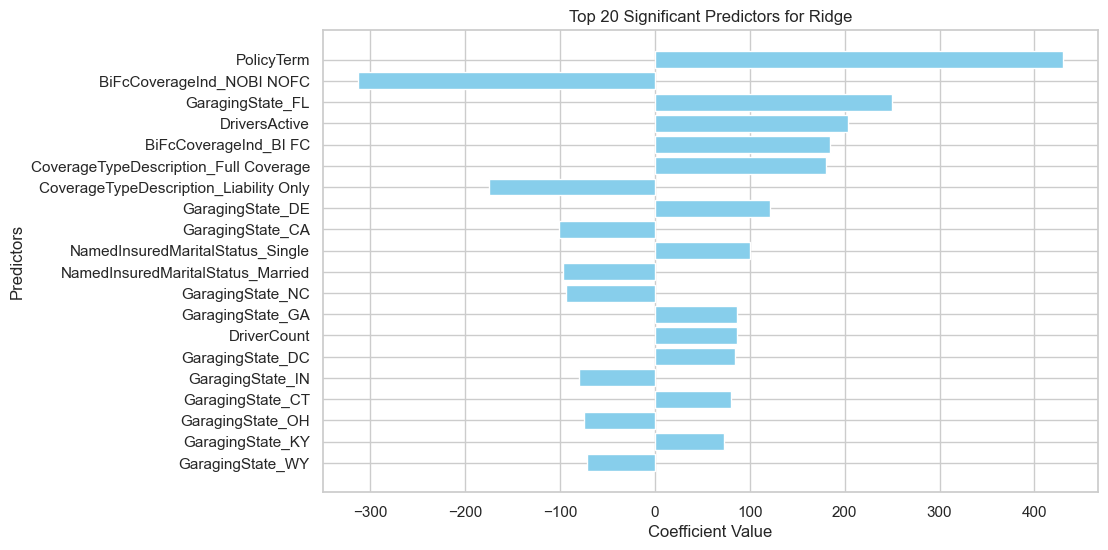

In [166]:
top_20_predictors = significant_predictors.loc[
    significant_predictors['Coefficient'].abs().nlargest(20).index
]

plt.figure(figsize=(10, 6))
plt.barh(top_20_predictors.index, top_20_predictors['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Top 20 Significant Predictors for Ridge')
plt.gca().invert_yaxis()  # Optional: Highest importance at the top
plt.show()


### Significant Predictors
* We can see that the 5 most significant predictors for the Ridge Regression model are policy term, NOFC coverage, garaging state of florida, drivers active, and FC coverage

## Creating Residuals
* This will help us understand how far off our predictions are

Now I will create a dataframe with the ridge predictions, the actual values, and the residuals which show how far off each prediction is

In [167]:
#y_residuals is teh new dataframe
y_residuals_ridge = pd.DataFrame(y_test.reset_index())

#df_lasso_pred contains the ridge predictions
df_ridge_pred = pd.DataFrame(ridge_pred)

#i will then merge the two dataframes
y_residuals_ridge = pd.concat([y_residuals_ridge, df_ridge_pred], axis = 1)

#then rename colum to lasso pred
y_residuals_ridge = y_residuals_ridge.rename(columns = {0:'ridge_pred'})

#creating column for the residuals
y_residuals_ridge['Residuals'] = y_residuals_ridge['MQuotedTotalPayment'] - y_residuals_ridge['ridge_pred']

#displaying teh new dataframe
y_residuals_ridge.head()

,index,MQuotedTotalPayment,ridge_pred,Residuals
0,5172,2446.00,1832.039638,613.960362
1,14265,1398.00,1563.182969,-165.182969
2,21343,456.00,-80.350758,536.350758
3,14528,665.00,19.081459,645.918541
4,23920,1401.92,2344.968627,-943.048627


Create a histogram that shows the ridge residuals

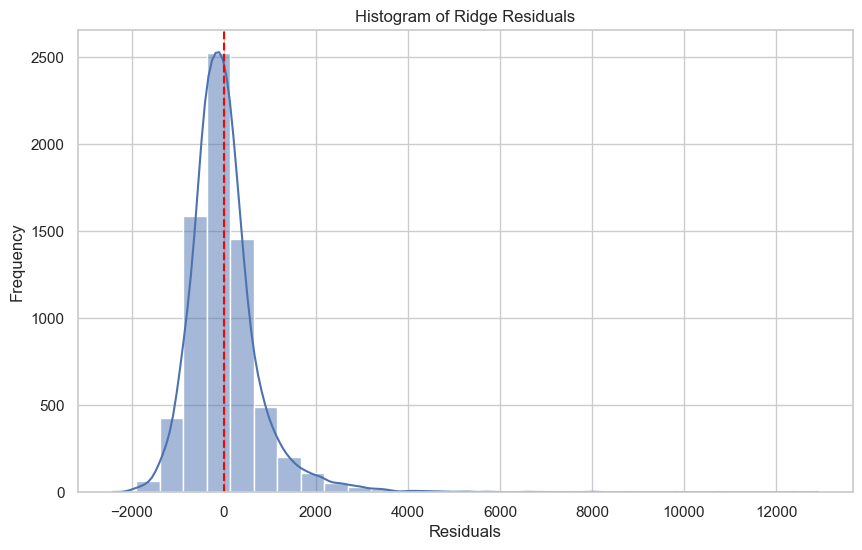

In [168]:
#plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_residuals_ridge['Residuals'], bins=30, kde=True)
plt.title('Histogram of Ridge Residuals') #title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Ridge Visualization
* This section will allow us to visualize the predictions compared to the actual values

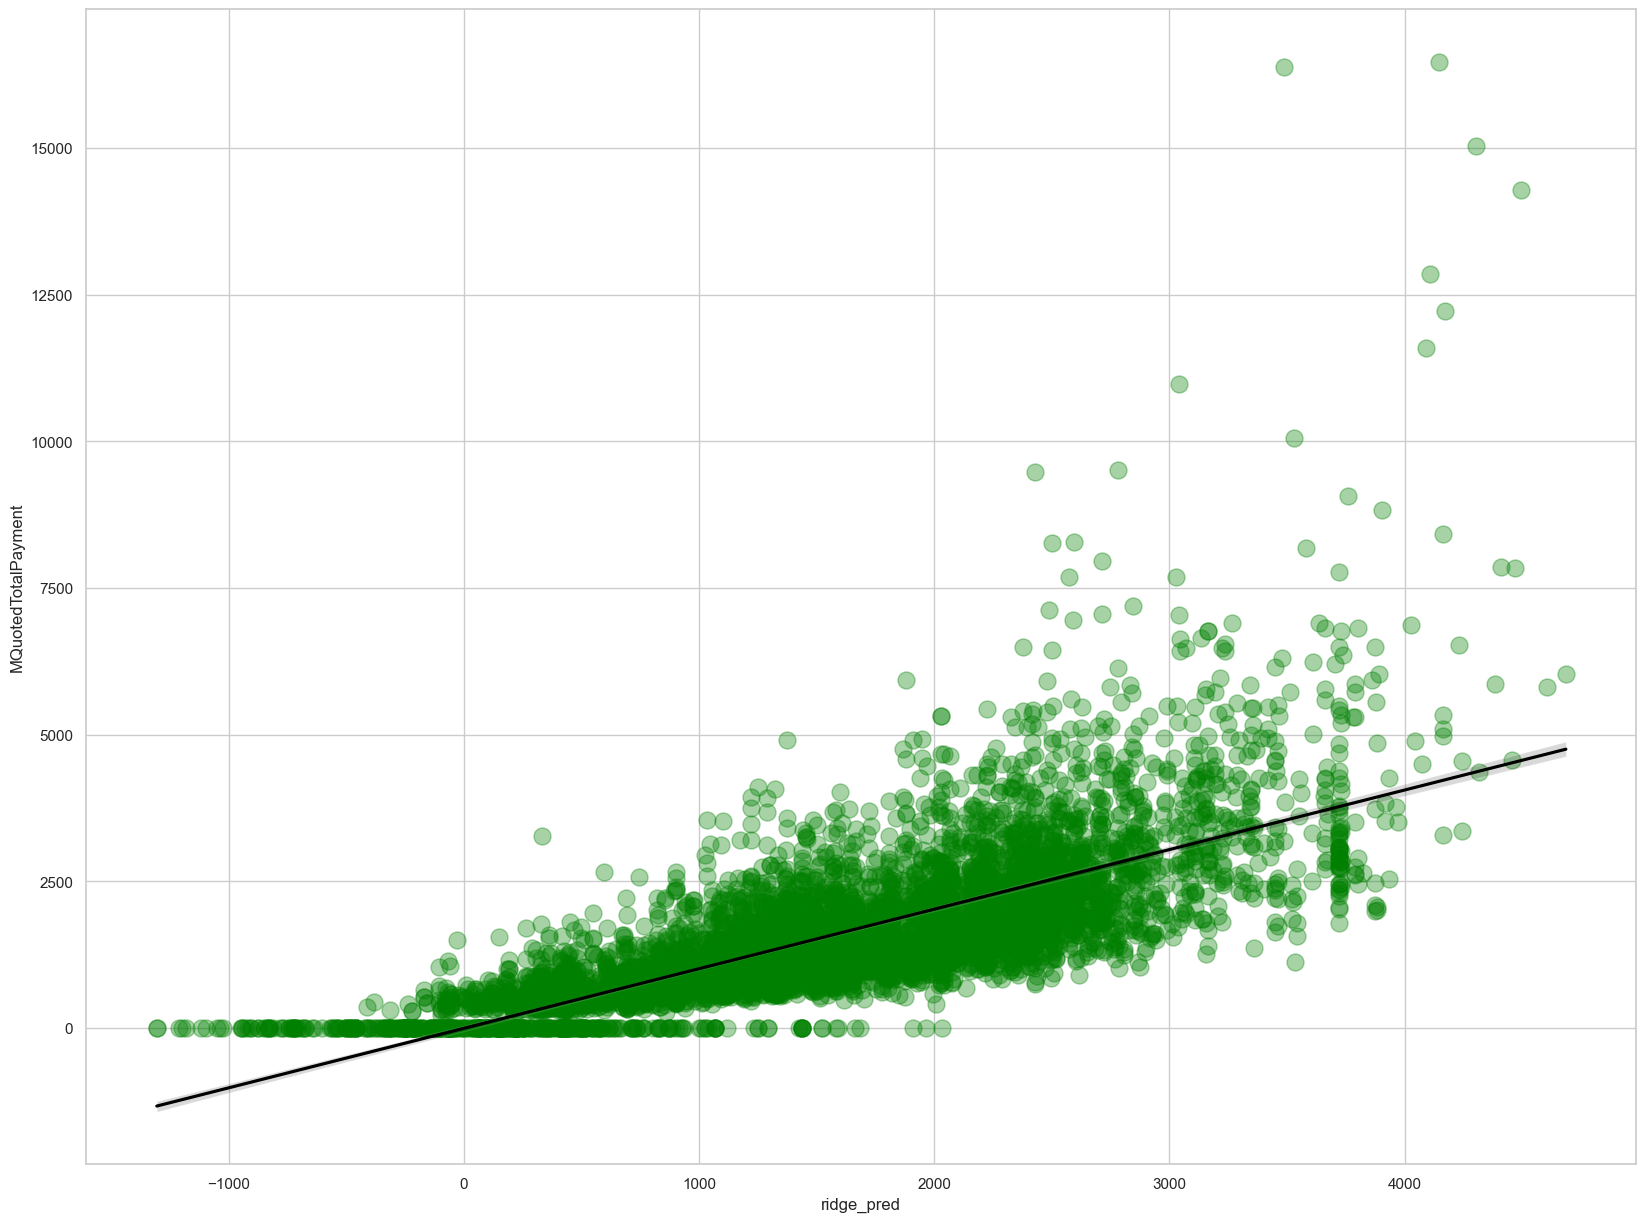

In [169]:
#using seaborn to create a visualization
sns.set(style='whitegrid')
plt.figure(figsize=(20,15)) #changes area of scatterplot
sns.regplot(x='ridge_pred', y='MQuotedTotalPayment', data = y_residuals_ridge, scatter_kws={"color":"green","alpha":0.35,"s":150},
           line_kws={'color': 'black'});

## Comparison Between Models

* This cell will include a visualization of both the Ridge and Lasso regression models

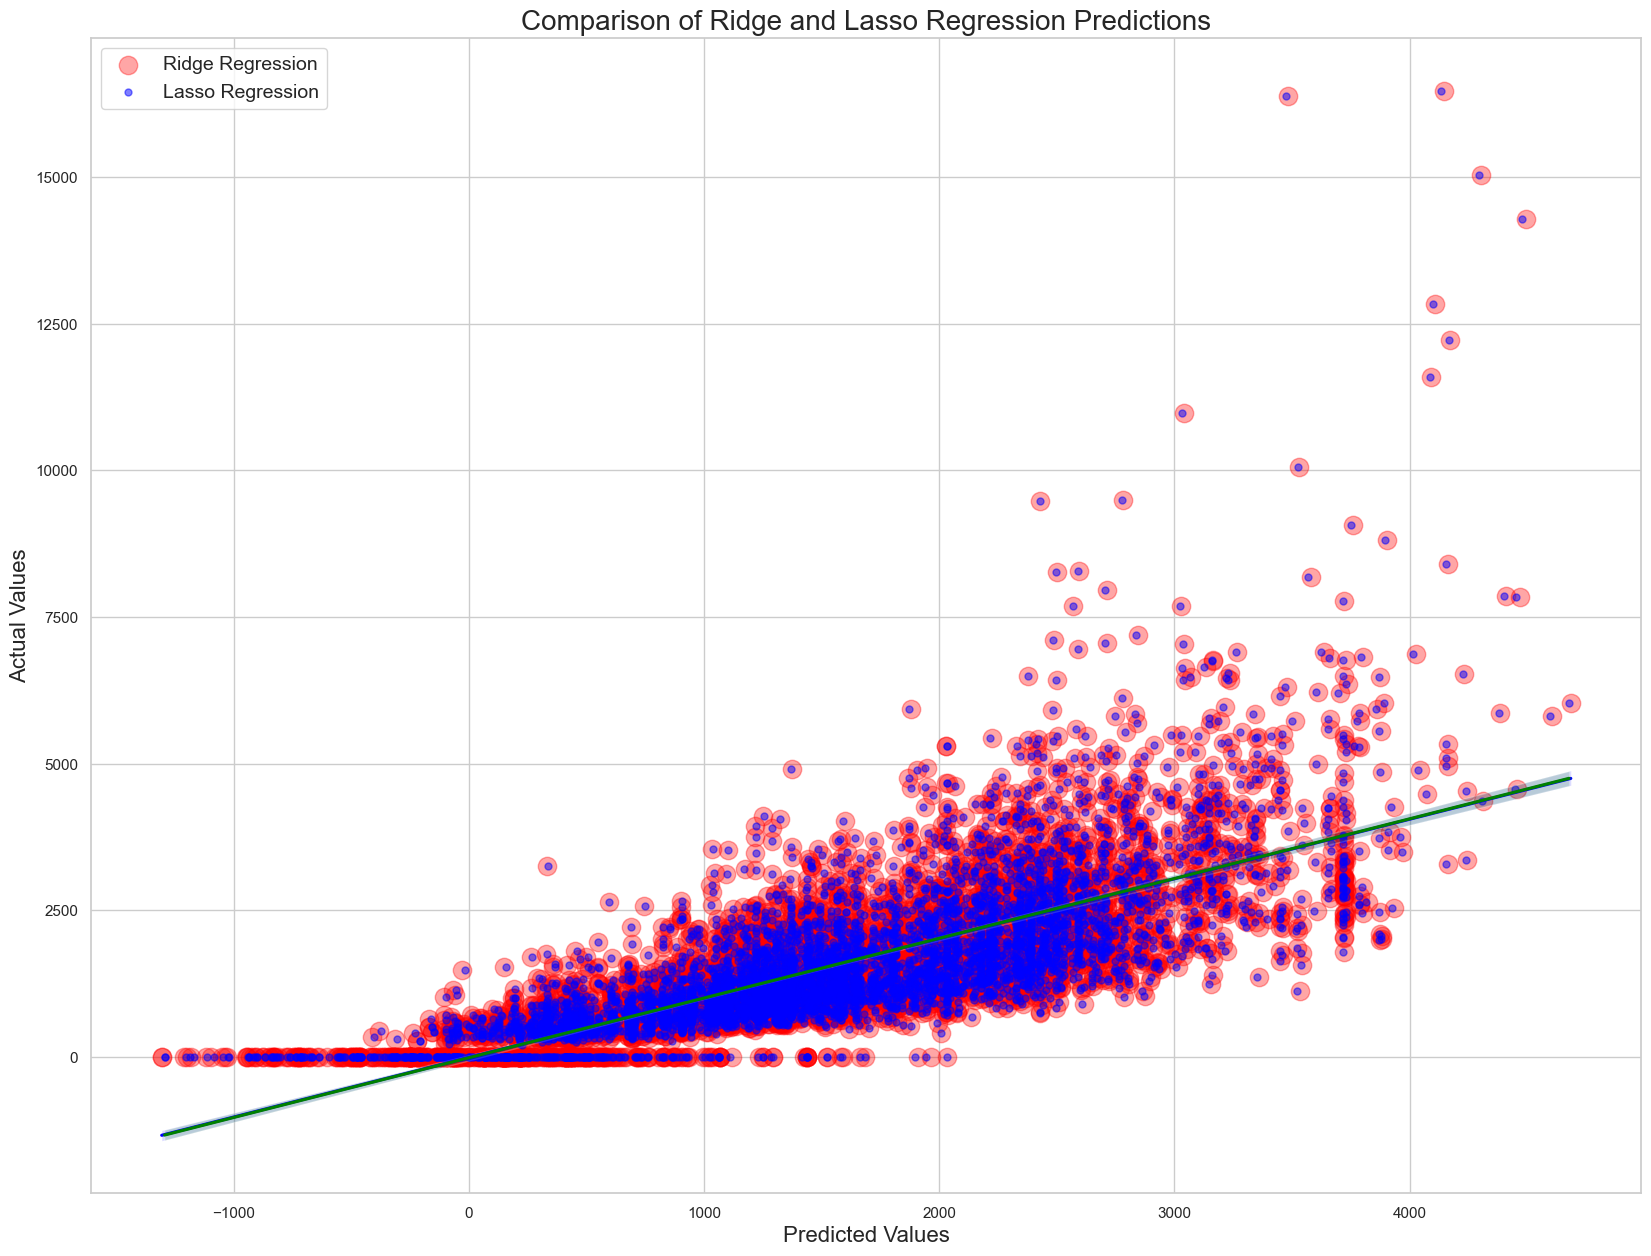

In [194]:
#Combines visualization for Lasso and Ridge


# Combined visualization for Lasso and Ridge
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))  # Adjust figure size

# Ridge regression scatterplot
sns.regplot(
    x='ridge_pred', 
    y='MQuotedTotalPayment', 
    data=y_residuals_ridge, 
    scatter_kws={"color": "red", "alpha": 0.35, "s": 175}, 
    line_kws={'color': 'blue'}, 
    label='Ridge Regression'
)

# Lasso regression scatterplot
sns.regplot(
    x='lasso_pred', 
    y='MQuotedTotalPayment', 
    data=y_residuals, 
    scatter_kws={"color": "blue", "alpha": 0.50, "s": 25}, 
    line_kws={'color': 'green'}, 
    label='Lasso Regression'
)

# Adding title, labels, and legend
plt.title("Comparison of Ridge and Lasso Regression Predictions", fontsize=20)
plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Actual Values", fontsize=16)
plt.legend(fontsize=14)
plt.show()

- We can see that the two models produce very similar outcomes

## Building the Random Forest Model
* I will assess the data using a random forest model
* I will then use grid search to ensure the best fit model

In [206]:
#Defining random forest model
rf_base = RandomForestRegressor(random_state=21)

#fit model based on training data
rf_base.fit(X_train, y_train)

#make predictions on traiing set
y_train_pred_rf = rf_base.predict(X_train)

#predictions on test set
y_test_pred_rf = rf_base.predict(X_test)

showing random forest predictions on each data split

In [207]:
print(f"Predictions on test data: {y_test_pred_rf}")

print(f"Predictions on train data: {y_train_pred_rf}")

Predictions on test data: [1213.58030495 1112.18003932  442.17811111 ...  671.69365891  816.14975999
 2903.82961486]
Predictions on train data: [1459.92541209  692.29733333 2644.2878759  ... 2022.76758043 1564.49099234
 3758.38035296]


In [208]:
y_hat_test = y_test_pred_rf

test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_hat_test)
test_r_squared = r2_score(y_test, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test, y_hat_test)

print(f'The test RMSE is:\t{round(test_rmse, 2)}')
print(f'The test MAE is:\t{round(test_mae, 2)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 2)}')
print(f'The test MAPE is:\t{round(test_mape, 2)}')

The test RMSE is:	803.38
The test MAE is:	483.31
The test Rsquared is:	0.57
The test MAPE is:	1.1130656410721422e+16


## Explaining Random Forest Test Statistics
* This code will explain in depth what each one of these statistics mean in relation to the model and dataset

#### RMSE
* 803.38
    * The RMSE measures the average difference between values predicted by a model and the actual values. In other words, it gives us an idea of how far, on average, the predictions are from the actual values.  This means that on average, the Random Forest model predictions are off by 803.38 units.  This RMSE is lower than both the Lasso and Ridge Models which means that on average the distance between the preditions and actual values are much less. This means that the random forest model is doing a better job predicting the target variable values (Total Payment) than the other two models as far as RMSE.
    
#### MAE
* 483.31
    * MAE is different from RMSE because it shows less significance to outliers. It calculates the average of the absolute differences between the predicted values and the actual values.  The MAE for the Random Forest model is 483.31 which means on average the predictions are off by about 483.31 units. This MAE is much smaller than both the Lasso and Ridge regression models which helps us further analyze that the Random Forest Model does the best job predicting the target variable Total Payment
    
#### R-Squared
* 57%
    * Rsquared measures the amount of variance in the target variable (in this case 'MQuotedTotalPayment').  The rsquared ranges from 0-1 where 1 means the model perfectly predicts the target variable while 0 means the model doesnt predict the target variable at all.  In this case, 57% of the variance in MQuotedTotalPayment can be explained by the predictor variables in the model. This is a good rsquared as it is nearing 60% and argues that the model does a good job predicting the target variable.  This cements the Random Forest model as the best prediction model of the three tested.
    
#### MAPE
* 111%
    * MAPE tells us how far off our prediction is from the actual value as a percentage.  This MAPE of 111% shows that our predictions are way off from the actual values in many columns and this coul dbe due to a large amount of outliers, or pieces of data that behave unpredictably.  This is a good statistic to understand how the data behaves.  In addition, it is important to note that while this MAPE is very high, it is still much loower than the LAsso and Ridge models

### Significant Predictors
* I will now assess the significant predictors according to the Random Forest model.  This can be done by assessing feature importance.
* I will then assess which features are not 0 which would imply importance.  The higher the importance, the more significant the predictor is

In [209]:
#displaying feature importance
feat_imp = pd.DataFrame(rf_base.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp = pd.concat([feat_imp, names], axis = 1)
df_feat_imp.columns = ['Importance', 'Features']
df_feat_imp.sort_values('Importance', ascending = False)

,Importance,Features
9,0.350852,CoverageTypeDescription_Full Coverage
1,0.152773,PolicyTerm
0,0.067683,DriversActive
3,0.065108,DriverCount
20,0.057515,GaragingState_FL
...,...,...
34,0.000757,GaragingState_MT
8,0.000147,CoverageTypeDescription_Bond
10,0.000129,CoverageTypeDescription_Liability Only
60,0.000018,NamedInsuredMaritalStatus_Domestic Partner


Now I will create a bar chart that helps me visualize which predictors are most important to the dataset

This bar chart will only contain the top 20 predictors to make the chart easier to read

<Figure size 1000x1500 with 0 Axes>

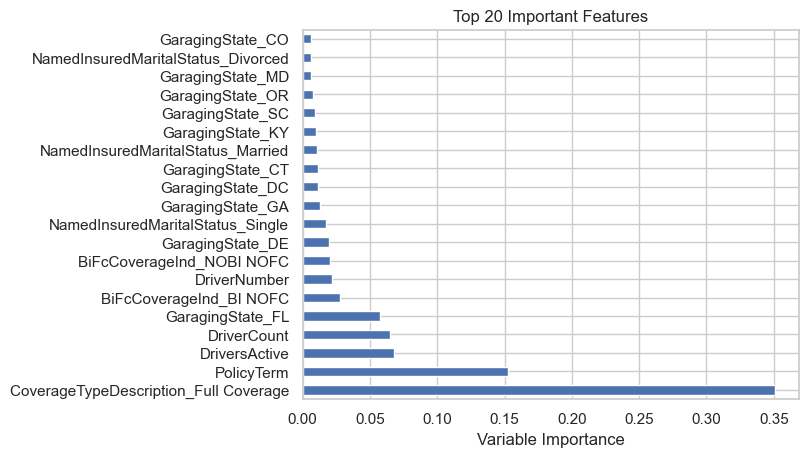

In [210]:
# Create a DataFrame for feature importances
Importance = pd.DataFrame({'Importance': rf_base.feature_importances_}, index=X.columns)

# Sort the feature importances in descending order to get the top features
Importance = Importance.sort_values('Importance', axis=0, ascending=False)

# Select the top 20 most important features
top_20_importance = Importance.head(20)

# Set the figure size to make the plot taller, improving readability
plt.figure(figsize=(10, 15))  # Width=10, Height=15 for a tall plot

# Plot the feature importances as a horizontal bar chart
top_20_importance.plot(kind='barh', color='b', linewidth=1)

# Set the x-label for the plot
plt.xlabel('Variable Importance')

# Remove the legend as it's unnecessary for this plot
plt.gca().legend_ = None

# Set the title for the plot
plt.title('Top 20 Important Features')

# Display the plot
plt.show()


### Significant Predictors
* We can see that the 5 most important features for the Random Forest model are Full Coverage type, Policy Term, Drivers active, Driver Count and garaging state of Florida.

## Random Forest Visualization
* I will visualize the random forest in multiple ways

This plot will show the predictions vs the true values

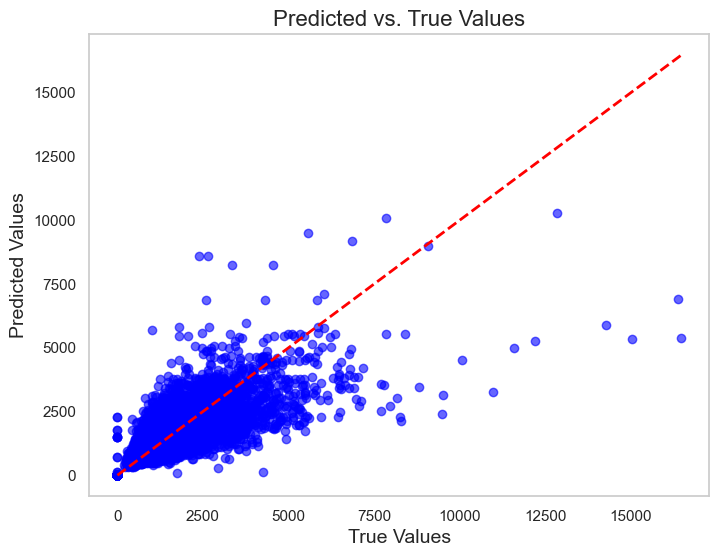

In [211]:
#scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_hat_test, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs. True Values for RF Model', fontsize=16)
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.grid()
plt.show()

This Cumulative Feature Importance plot will provide insight into how much of the total predictove power of a model is accounted for by the most important features

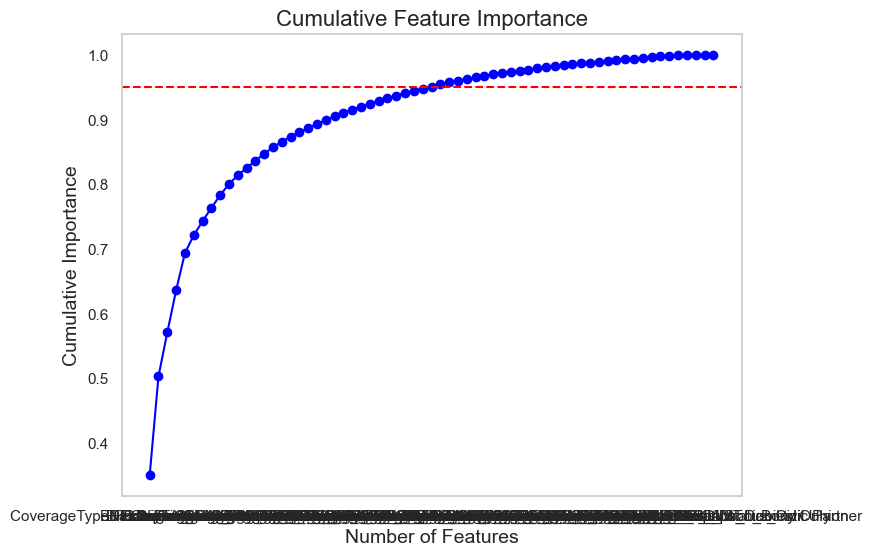

In [214]:
#importance plot
cumulative_importance = Importance['Importance'].cumsum()

plt.figure(figsize=(8, 6))
plt.plot(cumulative_importance, marker='o', linestyle='-', color='blue')
plt.axhline(y=0.95, color='red', linestyle='--')  # Threshold at 95%
plt.title('Cumulative Feature Importance', fontsize=16)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.grid()
plt.show()


## Best Fit Random Forest
* This will use grid search to find the best fit model for random forest regression

In [36]:
#first define parameter grid
param_grid_rf = [
    {
        "criterion": ['squared_error', 'absolute_error'],
        "n_estimators": [100, 150, 200],
        "max_depth": [3, 4, 5],
        "max_features": ['sqrt', 'log2']
    }
]


#Initialize grid search
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',  # Metric for regression
    cv=5,                              # 5-fold cross-validation
    verbose=2,                         # Show progress
    n_jobs=-1                          # Use all available processors
)


#fitting grid search on the training data
grid_search_rf.fit(X_train, y_train)

#getting the best model and parameters
best_rf_model = grid_search_rf.best_estimator_
best_params = grid_search_rf.best_params_


#printing best parameters
print("\nBest Hyperparameters:", best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



KeyboardInterrupt



Now I will make prediction using the best model

In [ ]:
y_test_pred_best = best_rf_model.predict(X_test)

#getting evaluation statistics
test_mse_best = mean_squared_error(y_test, y_test_pred_best)
test_rmse_best = np.sqrt(test_mse_best)
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_r_squared_best = r2_score(y_test, y_test_pred_best)
test_mape_best = mean_absolute_percentage_error(y_test, y_test_pred_best)

#printing out results
print(f'\nTest Metrics for Best Model:')
print(f'Test RMSE:\t{round(test_rmse_best, 2)}')
print(f'Test MAE:\t{round(test_mae_best, 2)}')
print(f'Test R-Squared:\t{round(test_r_squared_best, 2)}')
print(f'Test MAPE:\t{round(test_mape_best, 2)}')

## Summary

* I ran 3 regression models to assess which one was the most accurate at predicting the target variable, 'MQuotedTotalPayment'. Out of the Lasso Regression Model, the Ridge Regression Model, and the Random Forest Regression Model, I was able to find the model that best predicted the target variable. The model that most accurately predicted the target variable was the Random Forest Model. I ran gridsearch on each regression model type to ensure the most accurate model was created.

* I made the decision that the Random Forest Regression Model was the best fit model by first assessing the RMSE. The RF model had a RMSE of 803.38 which means that on average, the Random Forest model predictions are off by 803.38 units. This is significantly smaller than the other two models RMSE: Lasso (828.15) and Ridge (828.08). The average distance between predicted values and actual values is over 20 units less than the Lasso and Ridge models.  Therefore the Random Forest model is the better fit model according to the RMSE test statistic.

* The second test statistic that helped me make the decision that the Random Forest model was the best fit model is the MAE.  The RF model had a MAE of 483.31 which means that the absolute distance between the predicted and actual values is 483.31.  The reason the MAE is much smaller than the RMSE is because it takes the absolute value and shows less significance to outliers. This MAE is much smaller than the Lasso and Ridge models in comparison: Lasso (534.32) and Ridge (534.66). The absolute distance between actual and predicted values is over 50 units less than the Lasso and Ridge models. Therefore the Random Forest model is a better fit model according to the MAE test statistic as well.

* The next test statistic that helped me make the decision that the Random Forest model is the best fit model is the Rsquared value. The RF model had a Rsquared of 57%. This means that 57% of the variance of the target variable (MQuotedTotalPayment) can be explained by the model. The Rsquared for the RF model is slightly greater than the other modes in comparison: Lasso (54%) and Ridge (54%). The difference in the amount of variance that can be predicted is 3% better in the Random Forest model than the other models which further shows that the Random FOrest model is the best fit model for the data.

* The final test statistic that helped me make the decision that the Random Forest model is the best fit model is the MAPE.  The RF model had a MAPE of 111%.  Though this MAPE is extremely high, it is still less than the Lasso (128%) and Ridge (129%) model's MAPE.  This extremely high MAPE is likely due to the abundance of outliers within the dataset.

* Based on the four test statistics: RMSE, MAE, Rsquared, and MAPE, the Random Forest model is the best fit prediction model which means that it most accurately predicts the target variable (MQuotedTotalPayment).  The Lasso and Ridge models did similar jobs at predicting the target variable while the Random Forest model surpassed them in every statistical category.

## Most Significant Predictors

* The five most important variables accoring to the Random Forest model were Full Coverage type, Policy Term, Drivers active, Driver Count and garaging state of Florida.  This means that these variables had the most influence on predicting the target variable 'MQuotedTotalPayment'.

* The five most significant predictors for the Ridge Regression model were policy term, NOFC coverage, garaging state of florida, drivers active, and FC coverage.  This means that these variables had the most influence on the model and were the most significant variables for predicting 'MQuotedTotalPayment'.

* The five most signifcant predictors for the Lasso Regression model were  FC coverage, Policy term, and NOFC coverage, Garaging state of Florida and drivers active.  This mean sthat these variables played a significant role in predicting 'MQuotedTotalPayment' in the lasso model.


* The three most significant predictors for all models are policy term, drivers active, garaging state of florida.  This means that these three variables play the most significance in predicting 'MQuotedTotalPayment' in all models.  When assessing the total payment, it woul dbe safe to look at these 3 variables to predict the value of quoted total payment.

This cell will include a visualization of both the Ridge and Lasso regression models

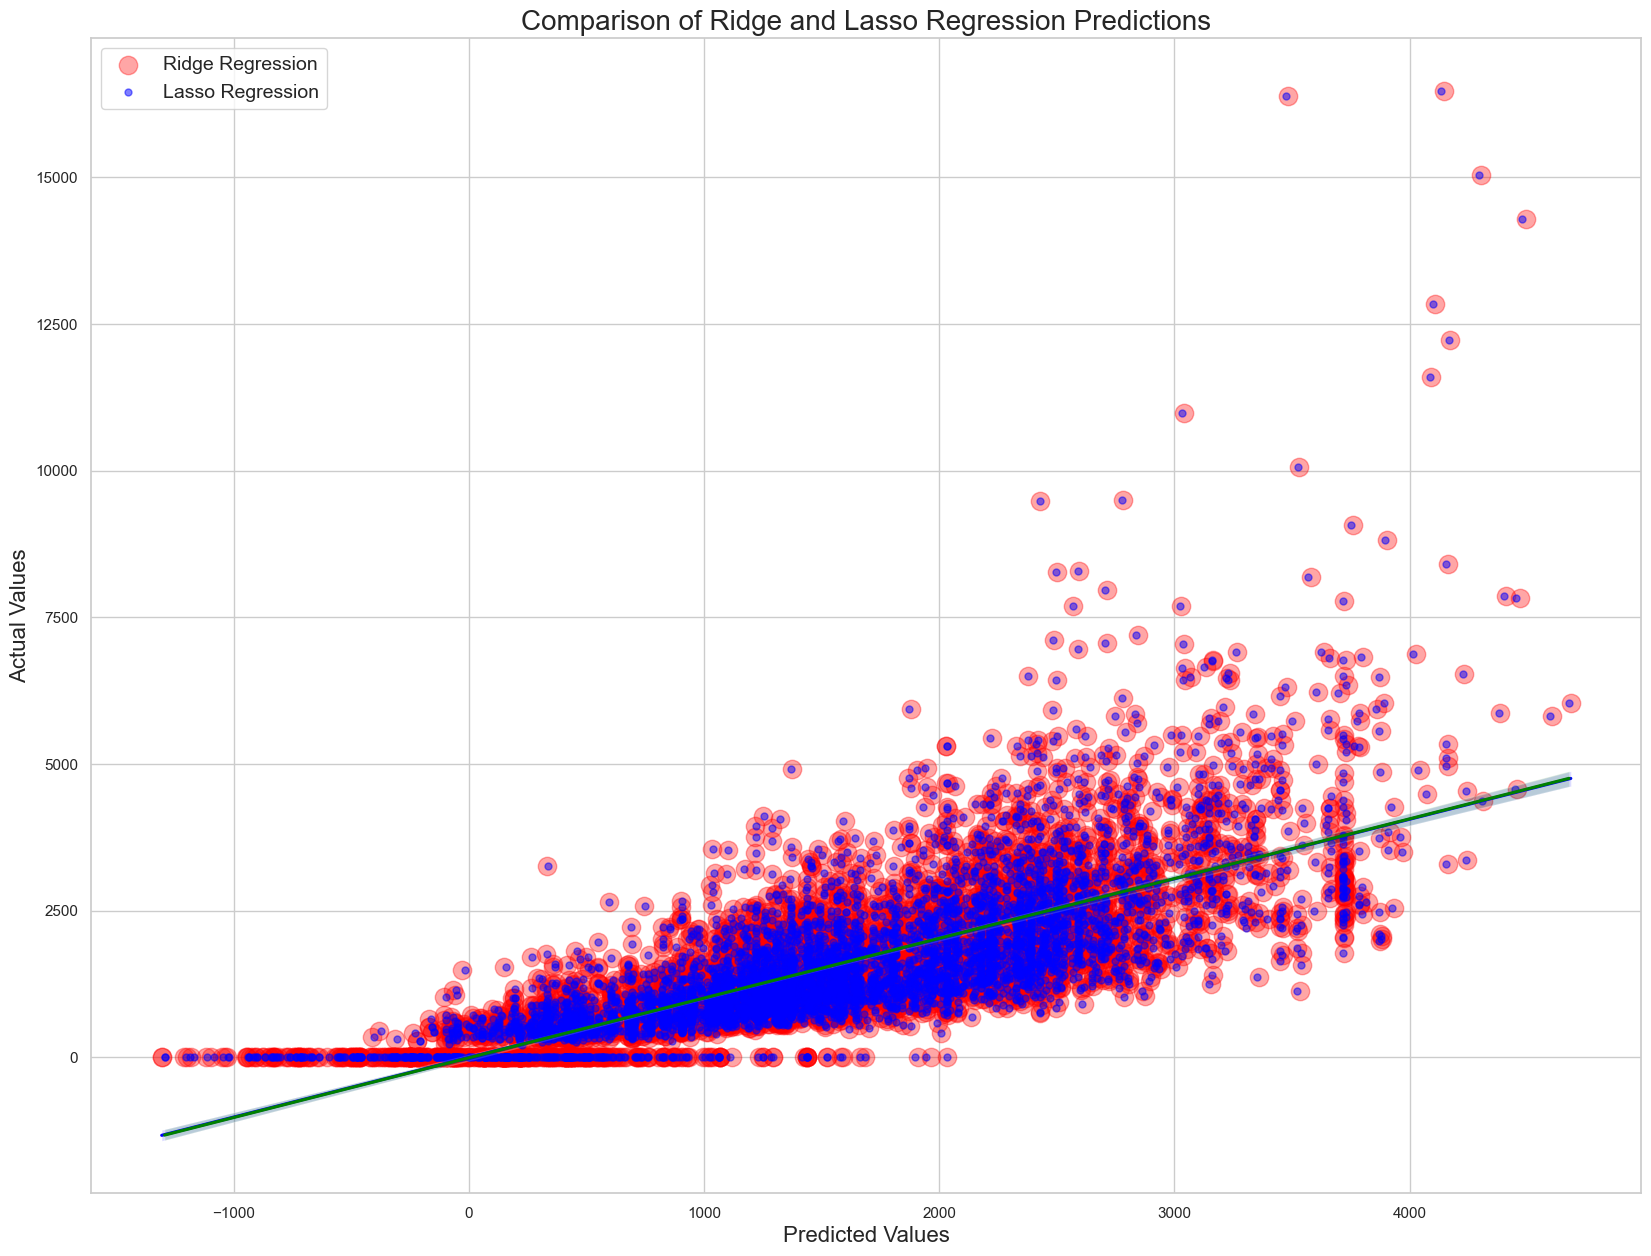

In [193]:
# Combined visualization for Lasso and Ridge
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))  # Adjust figure size

# Ridge regression scatterplot
sns.regplot(
    x='ridge_pred', 
    y='MQuotedTotalPayment', 
    data=y_residuals_ridge, 
    scatter_kws={"color": "red", "alpha": 0.35, "s": 175}, 
    line_kws={'color': 'blue'}, 
    label='Ridge Regression'
)

# Lasso regression scatterplot
sns.regplot(
    x='lasso_pred', 
    y='MQuotedTotalPayment', 
    data=y_residuals, 
    scatter_kws={"color": "blue", "alpha": 0.50, "s": 25}, 
    line_kws={'color': 'green'}, 
    label='Lasso Regression'
)

# Adding title, labels, and legend
plt.title("Comparison of Ridge and Lasso Regression Predictions", fontsize=20)
plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Actual Values", fontsize=16)
plt.legend(fontsize=14)
plt.show()


This cell will include a visualization for the Random Forest model which displays the prediction vs true values in a scatter plot

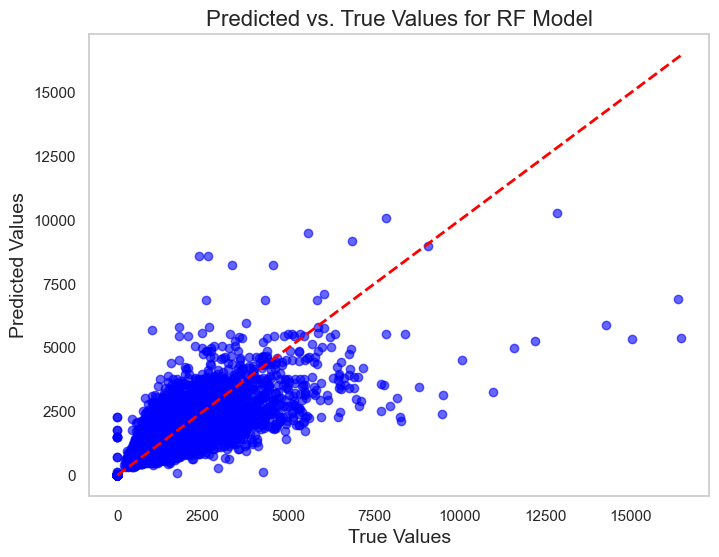

In [217]:
#scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_hat_test, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs. True Values for RF Model', fontsize=16)
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.grid()
plt.show()

we can see that the random forest model is more condensed in the bottom left corner. which means that the values are low.  However we can also see that the random forest model is a great model for predicting MQuotePayment.